<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

# Constraint analysis of a single engine small UAV

Based on the example in *"Small Unmanned Fixed-wing Aircraft Design: A Practical Approach"* by Keane, Sóbester and Scanlan.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

First, we set up a dictionary variable containing elements of the design brief. All of the requirements below refer to ISA standard day conditions (see the documentation for the ``Atmosphere`` class for how to instantiate other atmospheres). The dictionary entry ``cruisethrustfact`` defines the throttle setting expected to be used in cruise (1 = full throttle).

In [2]:
designbrief = {'rwyelevation_m':0, 'groundrun_m':60, # <- Take-off requirements
               'stloadfactor': 1.41, 'turnalt_m': 0, 'turnspeed_ktas': 40, # <- Turn requirements
               'climbalt_m': 0, 'climbspeed_kias': 46.4, 'climbrate_fpm': 591, # <- Climb requirements
               'cruisealt_m': 122, 'cruisespeed_ktas': 58.3, 'cruisethrustfact': 1.0, # <- Cruise requirements
               'servceil_m': 152, 'secclimbspd_kias': 40, # <- Service ceiling requirements
               'vstallclean_kcas': 26.4} # <- Required clean stall speed

Some constraints may not have to be satisfied at MTOW - ``wfract`` specifies the weight fraction corresponding to each constraint:

In [3]:
wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 1.0, 'servceil': 1.0}

These fractions, as well as some basic design parameters are specified in the ``designdefinition`` dictionary: aspect ratio, leading edge sweep, sweep of the maximum thickness line of the wing and the engine bypass ratio.

In [4]:
designdefinition = {'aspectratio':9.0, 'sweep_le_deg':2, 'sweep_mt_deg':0, 'weightfractions':wfract} 

We next define some design performance estimates, e.g., the propeller efficiencies ($\eta_\mathrm{prop}$) corresponding to the various constraints, drag and lift coefficients and the wheel rolling resistance coefficient:

In [5]:
etap = {'take-off': 0.6, 'climb': 0.6, 'cruise': 0.6, 'turn': 0.6, 'servceil': 0.6}

designperformance = {'CDTO':0.0898, 'CLTO':0.97, 'CLmaxTO':1.7, 'CLmaxclean': 1.0, 'mu_R':0.17, 
                     'CDminclean':0.0418, 'etaprop': etap}

Initial estimate of the take-off weight:

In [6]:
TOW_kg = 15.0

Define the atmosphere in which the calculations are to be conducted - in this case the International Standard Atmosphere. Other atmospheres available in the ``Atmospheres`` class: off-standard ISAs, MIL-HDBK-310 and bespoke atmospheres.

In [7]:
designatm = at.Atmosphere()

We are now ready to instantiate the aircraft concept object, with a propulsion type specifier for generic piston engine aircraft:

In [8]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, "piston")

We define a range of wing loadings for which we want to compute the required power:

In [9]:
wingloadinglist_pa = np.arange(25, 2500, 2.5)

And the main event: we call the power calculation method, as well as the method for calculating the minimum area dictated by the stall requirement:

In [10]:
preq = concept.powerrequired(wingloadinglist_pa, TOW_kg) 

Smin_m2 = concept.smincleanstall_m2(TOW_kg)

## Power versus wing area

We can now generate a plot of the various constraint curves in the power versus wing area space:

In [11]:
#%matplotlib notebook

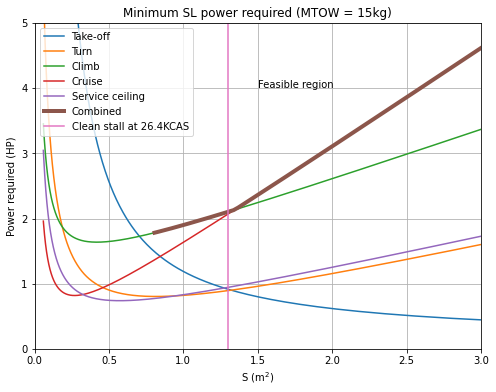

In [12]:
wingarea_m2 = co.kg2n(TOW_kg) / wingloadinglist_pa # x axis

plt.rcParams["figure.figsize"] = [8,6]
plt.plot(wingarea_m2, preq['take-off'], label = 'Take-off')
plt.plot(wingarea_m2, preq['turn'], label = 'Turn')
plt.plot(wingarea_m2, preq['climb'], label = 'Climb')
plt.plot(wingarea_m2, preq['cruise'], label = 'Cruise')
plt.plot(wingarea_m2, preq['servceil'], label = 'Service ceiling')
combplot = plt.plot(wingarea_m2, preq['combined'], label = 'Combined')
plt.setp(combplot, linewidth=4)
stall_label = 'Clean stall at ' + str(designbrief['vstallclean_kcas']) + 'KCAS'
plt.plot([Smin_m2, Smin_m2], [0, 1500], label = stall_label)
legend = plt.legend(loc='upper left')
plt.ylabel("Power required (HP)")
plt.xlabel("S (m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(0, 3)
plt.ylim(0, 5)
plt.grid(True)
plt.text(1.5, 4, 'Feasible region')
plt.show()

## T/W versus wing loading

In [13]:
twreq = concept.twrequired(wingloadinglist_pa)

In [14]:
# Calculate the max wing loading, as driven by the clmax in the approach configuration
# (use the ADRpy method for the clean stall W/S requirement and scale it with approach Clmax)

clmaxapproach = 1.3
WSmax_clean_stall = concept.wsmaxcleanstall_pa()
WSmax_approach_stall = WSmax_clean_stall / concept.clmaxclean * clmaxapproach
print(WSmax_approach_stall)

146.87035360551016


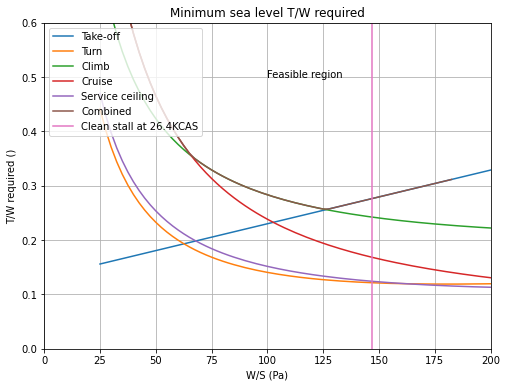

In [15]:
plt.rcParams["figure.figsize"] = [8,6]
plt.plot(wingloadinglist_pa, twreq['take-off'], label = 'Take-off')
plt.plot(wingloadinglist_pa, twreq['turn'], label = 'Turn')
plt.plot(wingloadinglist_pa, twreq['climb'], label = 'Climb')
plt.plot(wingloadinglist_pa, twreq['cruise'], label = 'Cruise')
plt.plot(wingloadinglist_pa, twreq['servceil'], label = 'Service ceiling')
combplot = plt.plot(wingloadinglist_pa, twreq['combined'], label = 'Combined')

plt.plot([WSmax_approach_stall, WSmax_approach_stall], [0, 0.6], label = stall_label)

legend = plt.legend(loc='upper left')
plt.ylabel("T/W required ()")
plt.xlabel("W/S (Pa)")
plt.title("Minimum sea level T/W required")
plt.xlim(0, 200)
plt.ylim(0, 0.6)
plt.grid(True)
plt.text(100, 0.5, 'Feasible region')
plt.show()

plt.show()

## Power versus wing loading

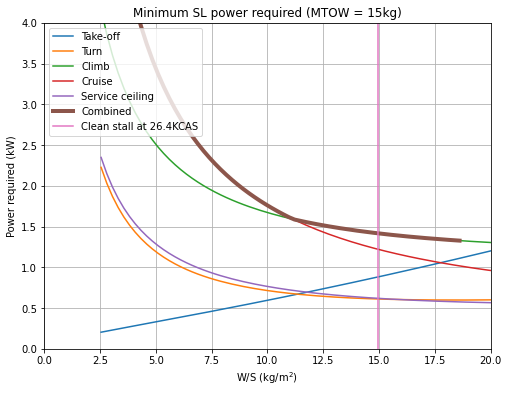

In [16]:
wingloadinglist_kgm2 = co.pa2kgm2(wingloadinglist_pa)

plt.rcParams["figure.figsize"] = [8,6]
plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['take-off']), label = 'Take-off')
plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['turn']), label = 'Turn')
plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['climb']), label = 'Climb')
plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['cruise']), label = 'Cruise')
plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['servceil']), label = 'Service ceiling')
combplot = plt.plot(wingloadinglist_kgm2, co.hp2kw(preq['combined']), label = 'Combined')

plt.setp(combplot, linewidth=4)


plt.plot([co.pa2kgm2(WSmax_approach_stall),
          co.pa2kgm2(WSmax_approach_stall)], [0, 5], label = stall_label)


legend = plt.legend(loc='upper left')
plt.ylabel("Power required (kW)")
plt.xlabel("W/S (kg/m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(0, 20)
plt.ylim(0, 4)
plt.grid(True)

plt.show()